<a href="https://colab.research.google.com/github/CarlosSMWolff/Quantum-Optics-Course/blob/main/2_Quantum_light_matter_interaction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quantum light-matter interaction

In this notebook, we will investigate fundamental light-matter Hamiltonians.

This time, we will first build our operators and Hamiltonians ourselves, using numpy arrays (the goal is to understand that it is quite easy to build our own codes without using Qutip). 

Then, we will come back to Qutip and investigate the limits of the semiclassical approximation, in which one assumes that the cavity states is and remains a coherent state.


Load necessary packages

In [1]:
!pip install qutip

# Load numpy for matrix operations
import numpy as np
# Load matplotlib to create plots
import matplotlib.pyplot as plt

from qutip import *

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 22.6 MB/s eta 0:00:00


# Hamiltonian construction and diagonalization with numpy

First we build the quantum operators that we use to describe the states and dynamics of the system.

In this example, we have a cavity (annihilation operator $a$) and a two-level system (lowering operator $\sigma$).

We will use the notation "red" for operators that act on the respective spaces of the cavity or the TLS alone, not in the global space that is a tensor product of both.

## Operators

In [2]:
# Define the annihilation operator for a single HO
ncav = 5 # Truncation number: i.e. number of levels of the HO included.

ared = np.zeros((ncav, ncav))
for i in range(1,ncav):
  ared[i-1,i] = np.sqrt(i)

# COMMENT: Here is a more elegant one-line command to to the same as above
# ared = np.diag(np.sqrt(np.arange(1,ncav)),k=1)

# Define the annihilation operator for a TLS
sigmared = np.array([[0,1],[0,0]])



Remember that we work in a Hilbert space which is a tensor product of the cavity Hilbert space and the TLS Hilbert space. Therefore, to build the operators we need to also build tensor products of the reduced operators defined above, for instance:

$$a_\text{total} = a_\text{cavity}\otimes I_{\text{TLS}} $$ 
$$\sigma_\text{total} = I_\text{cavity}\otimes \sigma_{\text{TLS}} $$

This tensor product is performed with numpy's Kronecker product ``np.kron``. The identity is created with ``np.eye``.



In [3]:
a = np.kron(ared,np.eye(2))
sigma = np.kron(np.eye(ncav),sigmared)

hilbertnumber = len(a)
print(f"The size of our combined Hilbert space is {hilbertnumber}")

The size of our combined Hilbert space is 10


These operators now act on the global space of both cavity and TLS, i.e. ,in the basis 

$$\{|g0\rangle, |e0\rangle, |g1\rangle, |e1\rangle, \ldots \} $$

To explicitly see this, we can apply the creation operation $a^\dagger$ to vacuum. Here, $a^\dagger$ is simply given by the transpose of a, which we can write as ``a.T``. Matrix multiplication can be done with ``np.dot`` or, even more easily, with the ``@`` operation. Remember that ``*`` does element-wise multiplication, not matrix multiplication!

In [4]:
vac = np.eye(hilbertnumber)[:,0] # Create vacuum state |g0> = (1,0,.... ,0)
sigma.T@vac

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])

We now define a function that will build the Hamiltonian matrix given the parameters of the system

In [5]:
def H_fun(params):
  wc, wq, g = params
  H = wc*a.T@a + wq* sigma.T@sigma + g*(a.T@sigma + a@sigma.T)
  return H

## Eigenvalues

Let's see the eigenvalues of this Hamiltonian as a function of the qubit frequency. We will set:

$g = 0.5$

$\omega_c = 3 $

These are not particularly realistic parameters for quantum optics (usually $g\ll \omega_c$) but it will make the visualization easier to understand.

The qubit frequency will start from values lower than $\omega_c$ and finish at values larger, so that both qubit and cavity are resonant at some point.



In [6]:
g = 0.5
wc = 3.

wqmin, wqmax, nwq = 1., 5., 100
wqgrid = np.linspace(wqmin, wqmax, nwq)


eigenvalues_wq = [ np.sort(np.linalg.eigvals(H_fun([wc, wq, g]))) for wq in wqgrid] # We build a list of eigenvalues 
eigenvalues_wq = np.asarray(eigenvalues_wq) # We turn the list into a numpy array

# For reference, we also compute eigenvalues for the uncoupled case
eigenvalues_wq_uncoupled = np.asarray([ np.sort(np.linalg.eigvals(H_fun([wc, wq, 0]))) for wq in wqgrid]) # We build a list of eigenvalues 


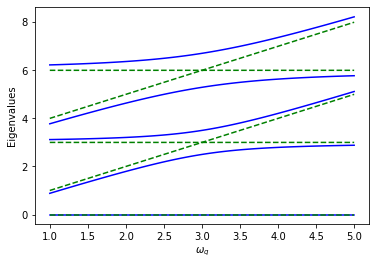

In [7]:
for i in range(5):
  plt.plot(wqgrid, eigenvalues_wq[:,i], color= 'blue')
for i in range(5):
  plt.plot(wqgrid, eigenvalues_wq_uncoupled[:,i], 'g--')
plt.xlabel("$\omega_q$"); plt.ylabel("Eigenvalues")
plt.show()

## Dynamics

Once we have built our Hamiltonian, one possible way of solving the dynamics is using the formal solution for the evolution operator

$$ \hat U(t) = e^{-i \hat H t} $$

Notice that this is a **matrix exponential**, not the exponential of the elements of the matrix! We can easily compute this with scipy's ```expm``` function.

In [10]:
from scipy.linalg import expm

Built a Hamiltonian and an initial state $|e0\rangle$

In [11]:
wq = wc
H = H_fun([wc, wq, g])
psi0 = sigma.T@vac

Define a grid of times and their corresponding $dt$

In [13]:
tini = 0.; tfin = 20.; nt = 100; 
tgrid = np.linspace(tini, tfin, nt)
dt = tgrid[1]-tgrid[0]

At each time step, we will apply $U(dt)$, which we just need to compute once

In [14]:
Udt = expm(-1j*H*dt)

We will now build a list of the wavefunction evaluated at the different $t$ in the array. The first element will be $|\psi(0)\rangle$, of course

In [17]:
# Initialize a list of wavefunctions
psi_list = [psi0]
psit = psi0

# Now we make a loop, applyting Udt in each iteration, and storing the state
for i in range(nt-1):
  psit = Udt@psit
  psi_list.append(psit)

We have a list of wavefunctions evaluated at different times. Let us check the qubit and photon population

In [25]:
def expect_np(operator, psi):
  return np.conj(psi)@operator@psi

In [26]:
nq_op = sigma.T@sigma
ncav_op = a.T@a

pop_qubit_time = np.real(np.asarray( [expect_np(nq_op, psi) for psi in psi_list]))
pop_cavity_time = np.real(np.asarray( [expect_np(ncav_op, psi) for psi in psi_list]))

Finally, we can see the Rabi oscillations:

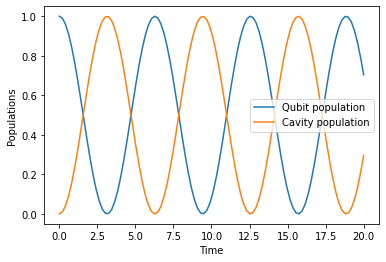

In [28]:
plt.plot(tgrid, pop_qubit_time, label= "Qubit population")
plt.plot(tgrid, pop_cavity_time, label = "Cavity population")
plt.xlabel("Time")
plt.ylabel("Populations")
plt.legend()
plt.show()

# Light-matter dynamics with Qutip

The way we define the creation and annihilation operators is similar to what we did before: we need to build a tensor product. Here, intead of numpy's ```kron``` we will use Qutip's ```tensor``` function. But, it is the same idea!

In [30]:
Ncav = 500 # Truncation number: nº of photons allowed the cavity +1

sigma = tensor(destroy(2),qeye(Ncav))
a = tensor(qeye(2), destroy(Ncav))

We define a Hamiltonian of the form 

$H = \Delta a^\dagger a + g(a \sigma^\dagger + a^\dagger \sigma)$

The main difference here is that now the operator are ***not*** numpy matrices, but Qutip Quantum Objects. Matrix multiplication with these Qutip operators are done with ```*```, not with ```@``` as we did before.

In [31]:
g = 1.
Delta = 0

H = Delta * a.dag()*a + g*(a.dag()*sigma + a*sigma.dag())

We will do a simulation using coherent states to explore the limits of semi-classical approximations.  Define initial state 

$|\psi_0\rangle = |g\rangle \otimes |\alpha\rangle$

In [33]:
alpha = np.sqrt(300)
psi0 = tensor(basis(2,0),coherent(Ncav,alpha))

Sanity check: Let's make sure that our cavity initial state is not populating the states close to our truncation and that we have a nice coherent state.

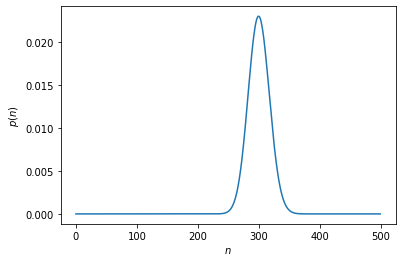

In [34]:
rho_cav = psi0.ptrace(1)
plt.plot(np.real(np.diag(rho_cav)))
plt.xlabel("$n$"), plt.ylabel("$p(n)$")
plt.show()

Define grid of times

In [35]:
tini, tfin, nt = 0., 10, 1000
times = np.linspace(tini,tfin,nt)

Compute time evolution: this time we use Qutip's built in function ```sesolve``` to solve the Schrodinger equation.

In [36]:
opts = Options()
opts.store_states = True
result = sesolve(H, psi0, times, [sigma.dag()*sigma, a.dag()*a],progress_bar=None,options = opts)

In [37]:
qubit_pop, cav_pop =result.expect

Here we can observe the effect of the collapse!

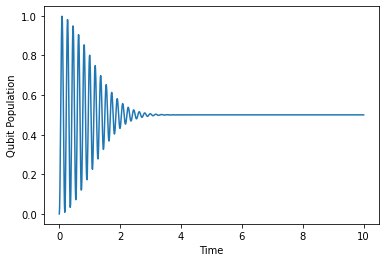

In [40]:
plt.plot(times, qubit_pop)
plt.xlabel("Time")
plt.ylabel("Qubit Population")
plt.show()

We can compute a witness of the entanglement of the system by checking the purity of the state resulting of taking the partial trace of one of the subsystems.

In [42]:
states = result.states
entanglement = [state.ptrace(0).purity() for state in states]

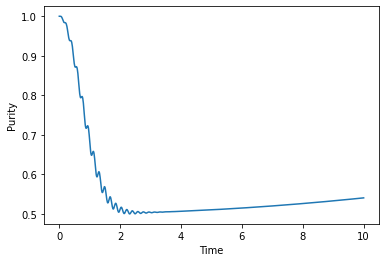

In [44]:
plt.plot(times, entanglement)
plt.xlabel("Time")
plt.ylabel("Purity")
plt.show()

We see that the purity reduces, meaning that the qubit-cavity are becoming entangled, and the semiclassical ansatz
$$|\psi(t)\rangle = (c_g|g\rangle + c_e|e\rangle)\otimes |\alpha\rangle$$

 is no longer valid (since entanglement means we cannot write the composite state as a tensor product).